# Testing learning agents #

In all these cases, the control MDP is a synthetic world with three waypoints and one threat. Thus every state has four available actions based on which point is being approached next. We also define specification MDPs with four different beliefs over specifications.

In [1]:
from utils import *
from SpecificationMDP import *
from LearningAgents import *
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [32,18]

In [2]:
def RecordLearningCurve(MDP, Learner, max_episodes = 10000, steps = 10, temp = 0.02, verbose = False):
    episodes = 0
    mean_rewards = []
    rewards = []
    std_rewards = []
    mean_episode_length = []
    ep = []
    
    for i in range(0,max_episodes,steps):
        
        if verbose:
            print(f'\r Training and evaluating with {i} episodes        ', end = '')
        
        episodes = episodes + steps
        ep.append(episodes)
        Learner.explore(episode_limit = steps)
        evaluator = ExplorerAgent(MDP, input_policy = Learner.create_learned_softmax_policy(temp))
        evaluator.explore(episode_limit = 100)
        r = [record[-1][3] for record in evaluator.episodic_record]
        l = [len(record) for record in evaluator.episodic_record]
        
        rewards.append(r)
        mean_rewards.append(np.mean(r))
        std_rewards.append(np.std(r))
        mean_episode_length.append(np.mean(l))
        
    return mean_rewards, std_rewards, mean_episode_length, ep
    
    

In [3]:
def ReportEvalStates(evaluator:ExplorerAgent):
    rewards = [record[-1][3] for record in evaluator.episodic_record]
    episode_lengths = [len(record) for record in evaluator.episodic_record]
    
    print('The average terminal reward was: ', np.mean(rewards))
    print('Std dev: ', np.std(rewards))
    print('The average episode length was: ', np.mean(episode_lengths))

## MDP1: Most restrictive formula is the most probable ##

Here the belief is comprised of three formulas namely

$$\varphi_1 = \mathbf{G}T0 ~\wedge~ \mathbf{F}W0 ~\wedge~ \mathbf{F}W1 ~\wedge~ \mathbf{F}W2 ~\wedge~ \neg W2 \mathbf{U} W0 ~\wedge~ \neg W1 \mathbf{U} W0 ~\wedge ~\neg W1 \mathbf{U} W0$$

This specifies that the agent should never enter the threat zone, All the subtasks should be completed and they should be completed in order 1,2,3

$$\varphi_2 = \mathbf{G}T0 ~\wedge~ \mathbf{F}W0 ~\wedge~ \mathbf{F}W1 ~\wedge~ \mathbf{F}W2$$

This specification states that the threat should never be visited and all the subtasks should be completed but no ordering contraints

$$\varphi_3 = \mathbf{G}T0 ~\wedge~ \mathbf{F}W0$$

This states that only the first subtask needs to be completed

The probabilities assigned are `[0.8, 0.15, 0.05]`. Lets defined the MDP and visualize the specification states

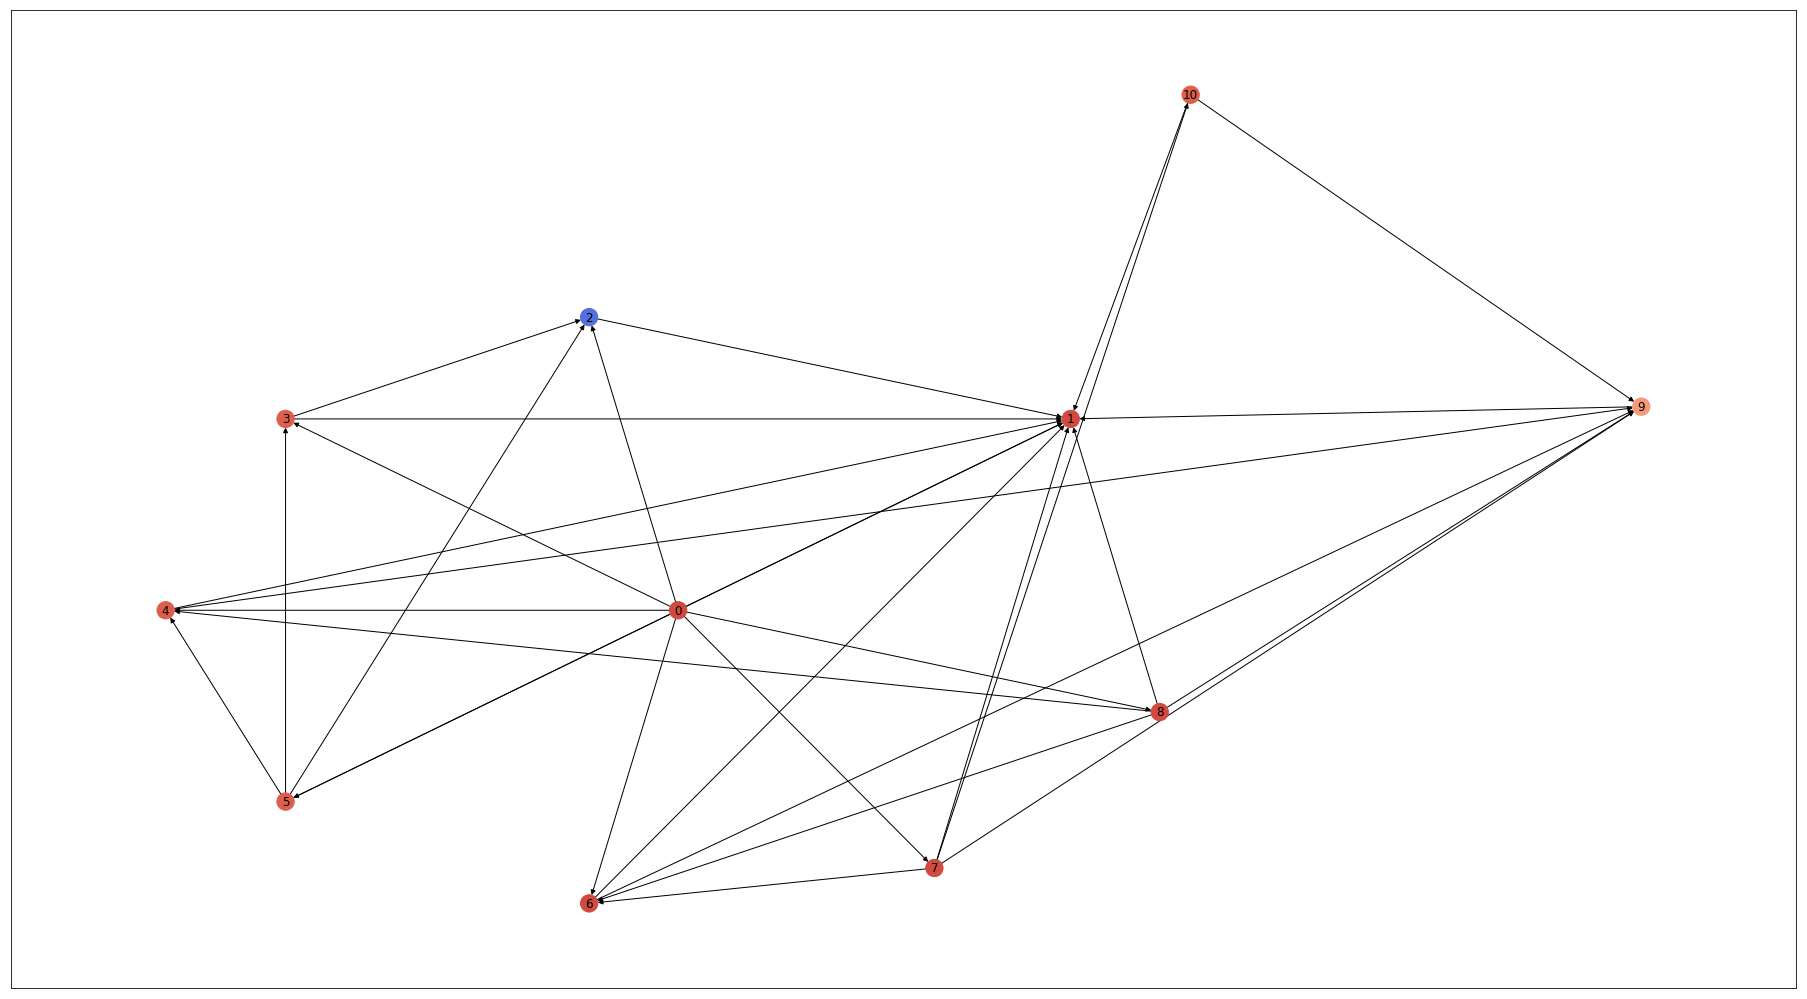

In [2]:
MDP1, fsm, cmdp = CreateSpecMDP1()
_ = fsm.visualize()

Lets plan with a vanilla Q-learning agent with 5000 episodes and then evaluate with a softmax agent with temperature 0.02

Training episode 4567         

[-1.0, -0.90000000000000002, -0.90000000000000002, 1.0, -0.90000000000000002]

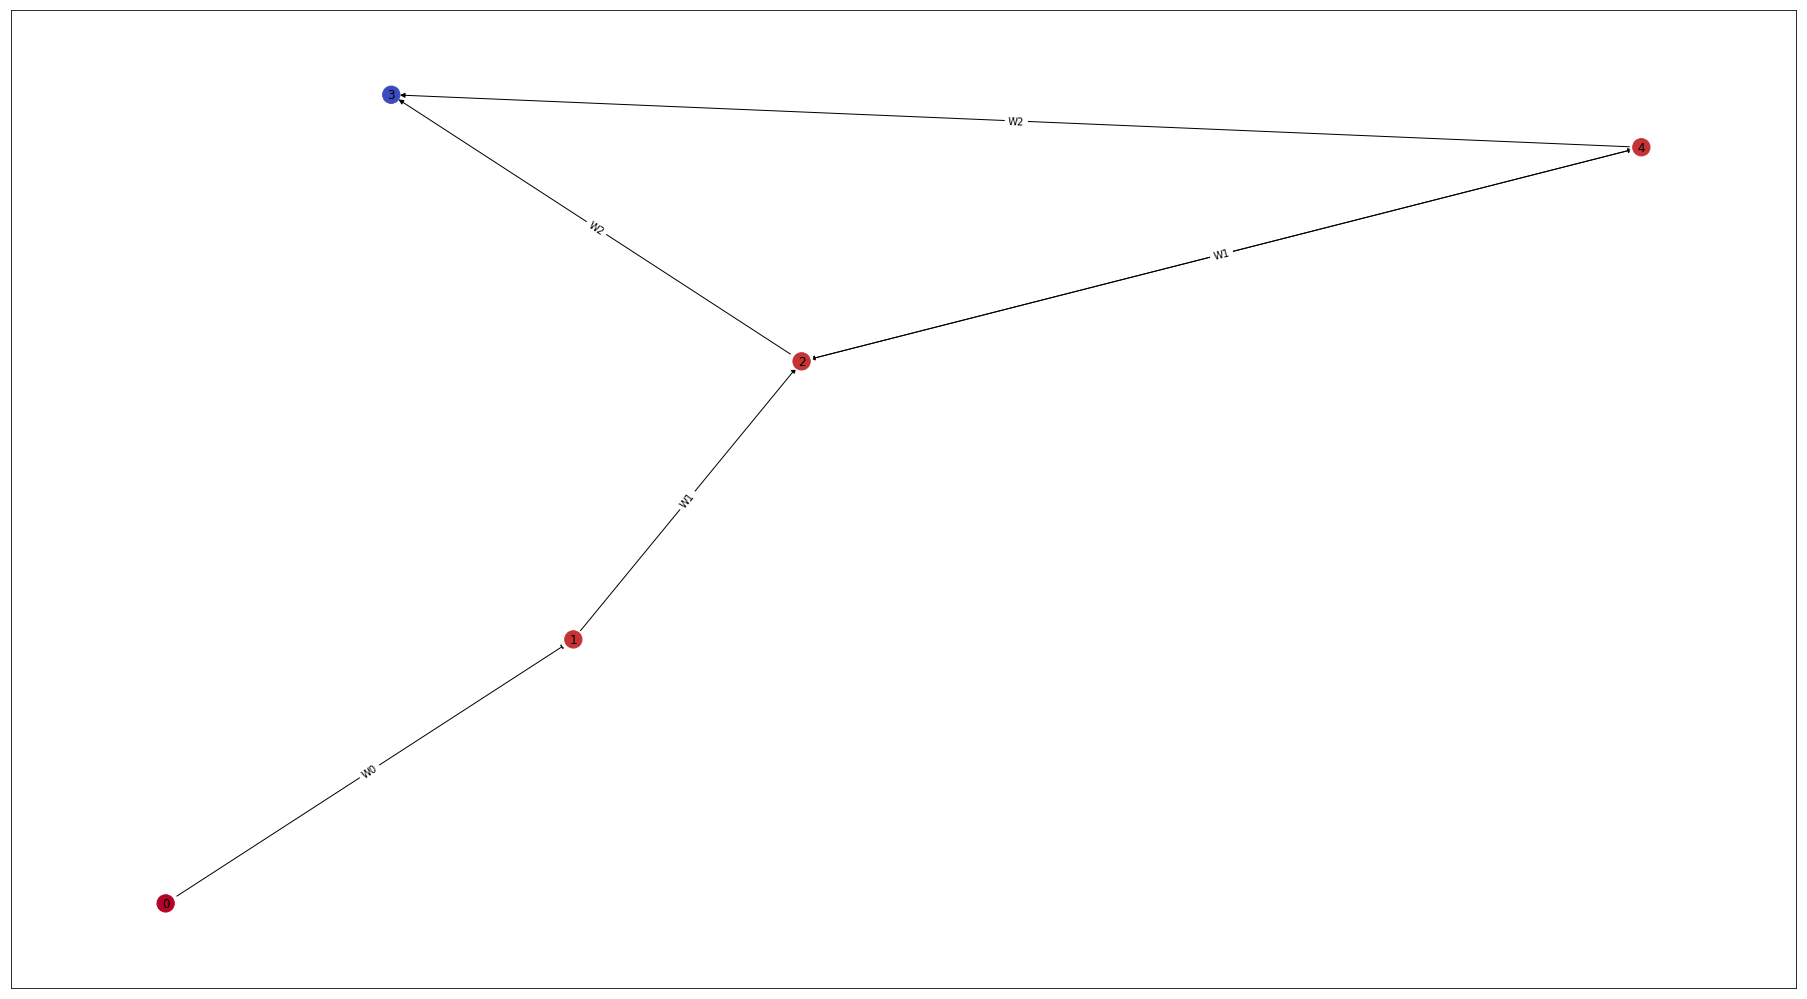

In [4]:
q_agent = QLearningAgent(MDP1)
(actions, episodes) = q_agent.explore(episode_limit = 5000, action_limit = 20000, verbose = True)

stoch_eval = ExplorerAgent(MDP1, input_policy = q_agent.create_learned_softmax_policy(0.02))
stoch_eval.explore(episode_limit = 1000)
_ = stoch_eval.visualize_exploration(prog='neato')

We see that for the most part, the agent takes the actions W0, W1, W2 in that order. In one of the runs it revisits W1 and then takes W2 but still these runs satisfy all the specifications. This is what we would expect of all the policies

In [15]:
ReportEvalStates(stoch_eval)

The average terminal reward was:  1.0
Std dev:  0.0
The average episode length was:  5.058


Lets look at the learning curve of Q-learning

 Training and evaluating with 45 episodes        

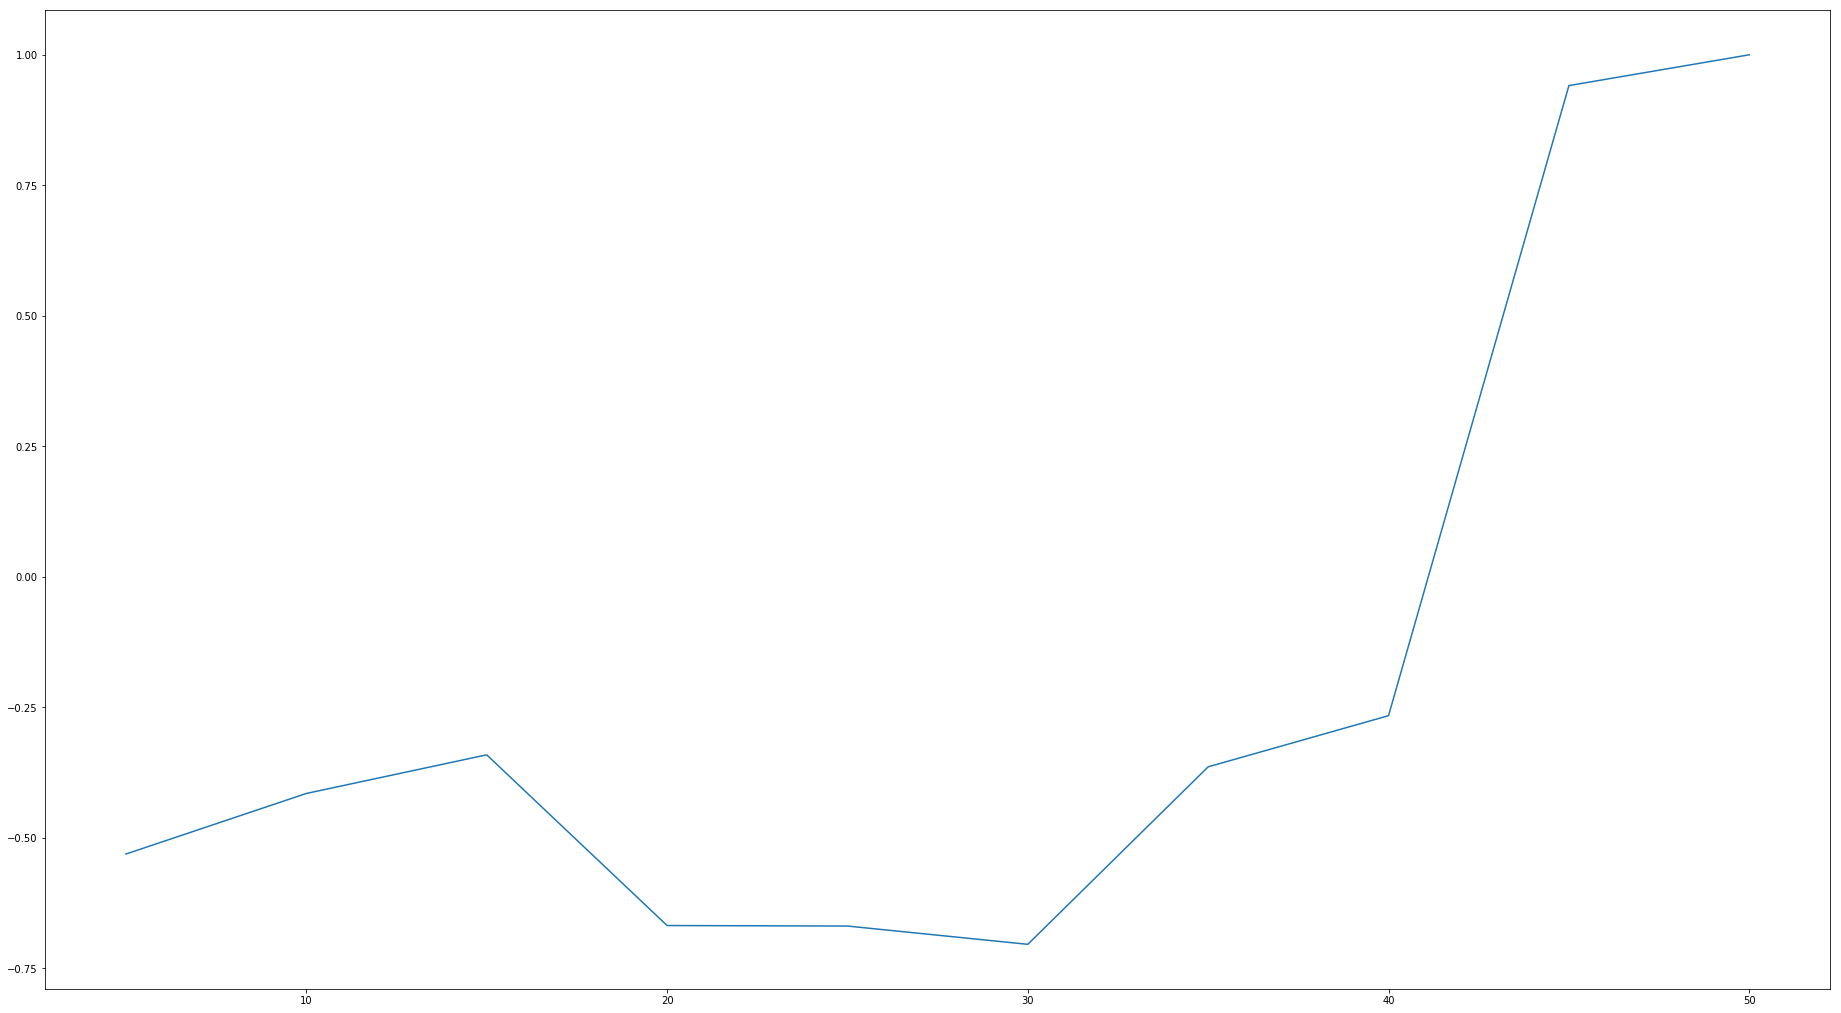

In [26]:
q_agent = QLearningAgent(MDP1)
LearningCurve = RecordLearningCurve(MDP1, q_agent, max_episodes=50, steps = 5, verbose = True)
plt.plot(LearningCurve[3], LearningCurve[0])

## MDP2: Most restrictive is the least probable

Lets do this in the minimum regret setting

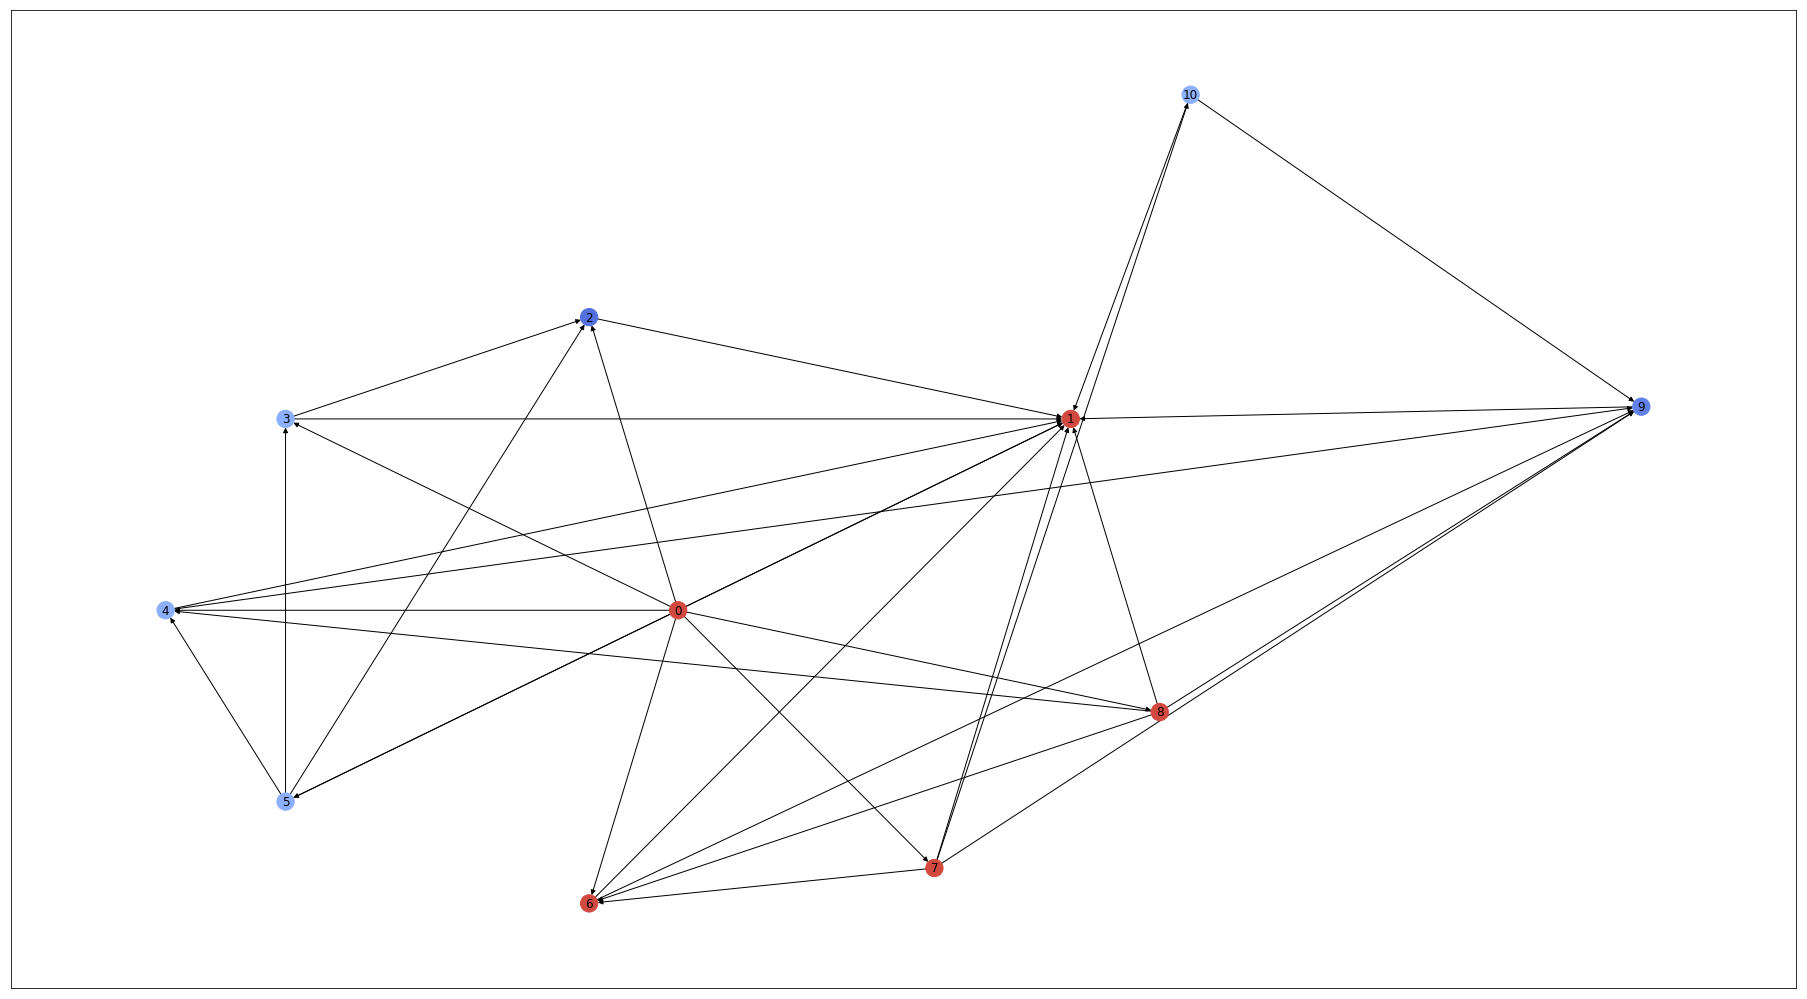

In [31]:
MDP2, fsm, cmdp = CreateSpecMDP2(reward_type='min_regret')
_ = fsm.visualize()

Training episode 999         The average terminal reward was:  0.9905
Std dev:  0.0293214938228
The average episode length was:  4.189


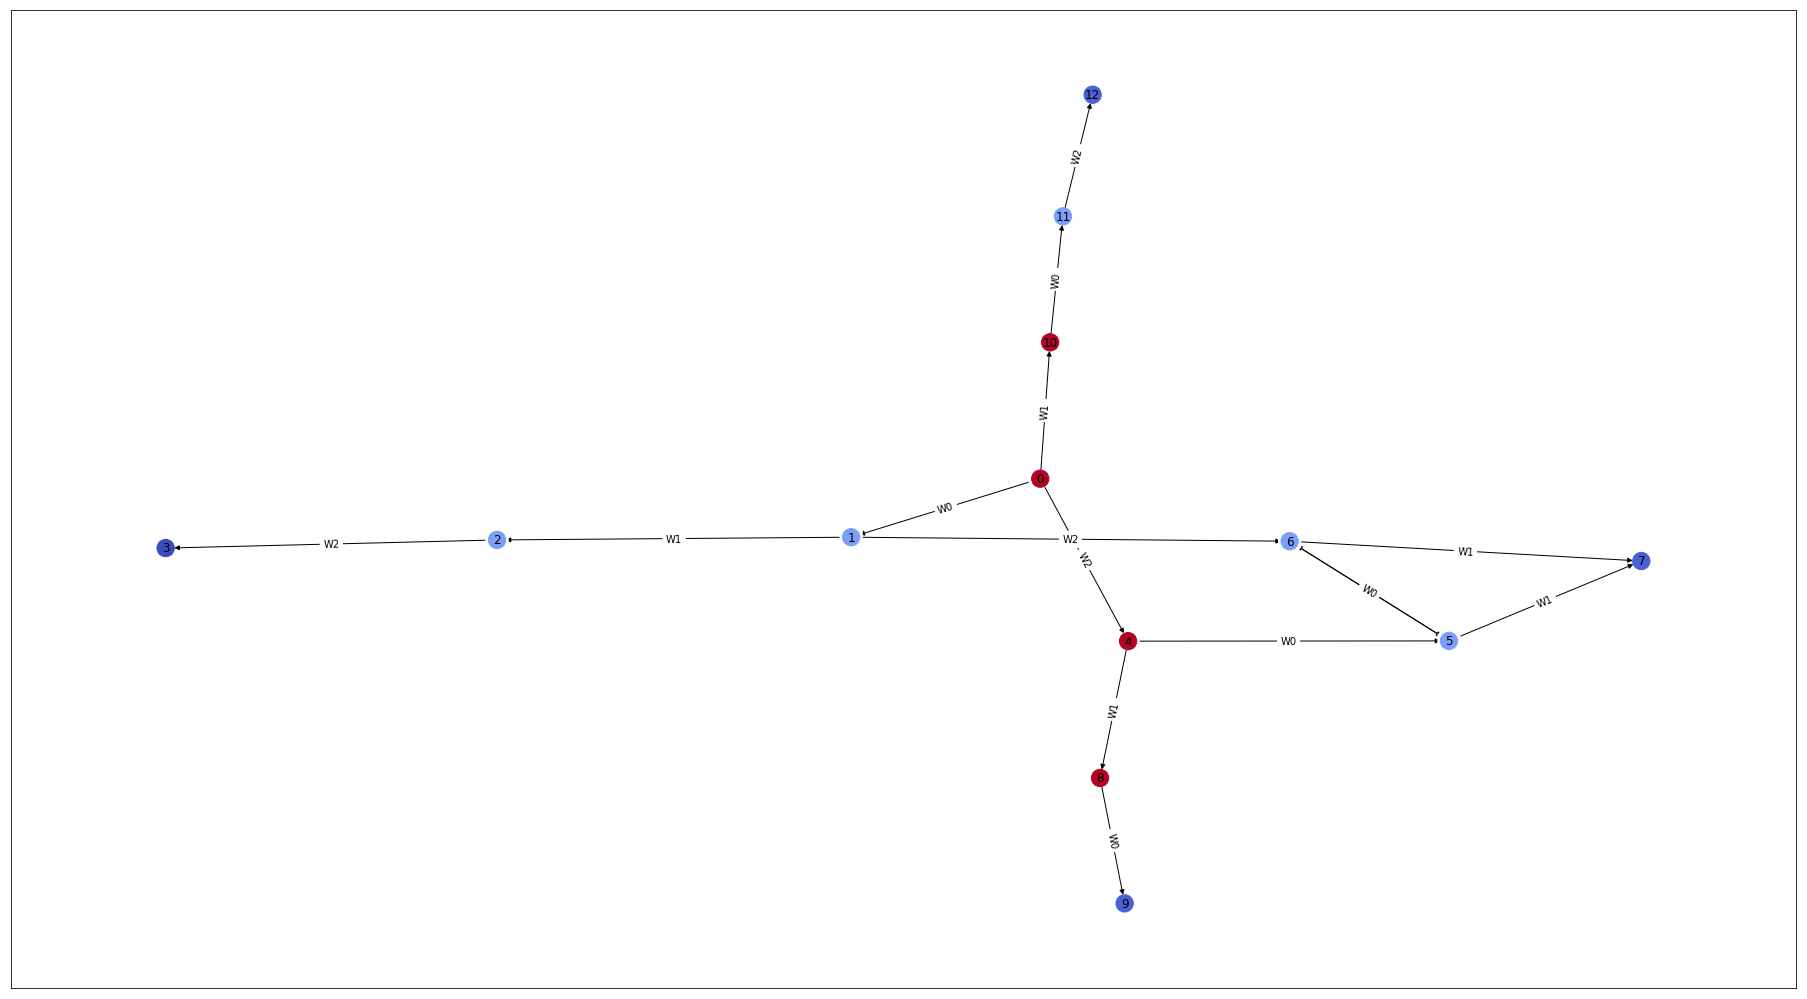

In [34]:
q_agent = QLearningAgent(MDP2)
q_agent.explore(episode_limit= 1000, verbose=True)

stoch_eval = ExplorerAgent(MDP2, input_policy = q_agent.create_learned_softmax_policy(0.02))
stoch_eval.explore(episode_limit = 1000)
_ = stoch_eval.visualize_exploration(prog='neato')

ReportEvalStates(stoch_eval)

The agent explored multiple ways of doing the task with only some of the path actually following the most restrictive specification. The average reward is still very high.

Lets look at what happens in the max coverage setting. We should expect more weight assigned to the most restrictive formula

Training episode 999         The average terminal reward was:  1.0
Std dev:  0.0
The average episode length was:  5.256


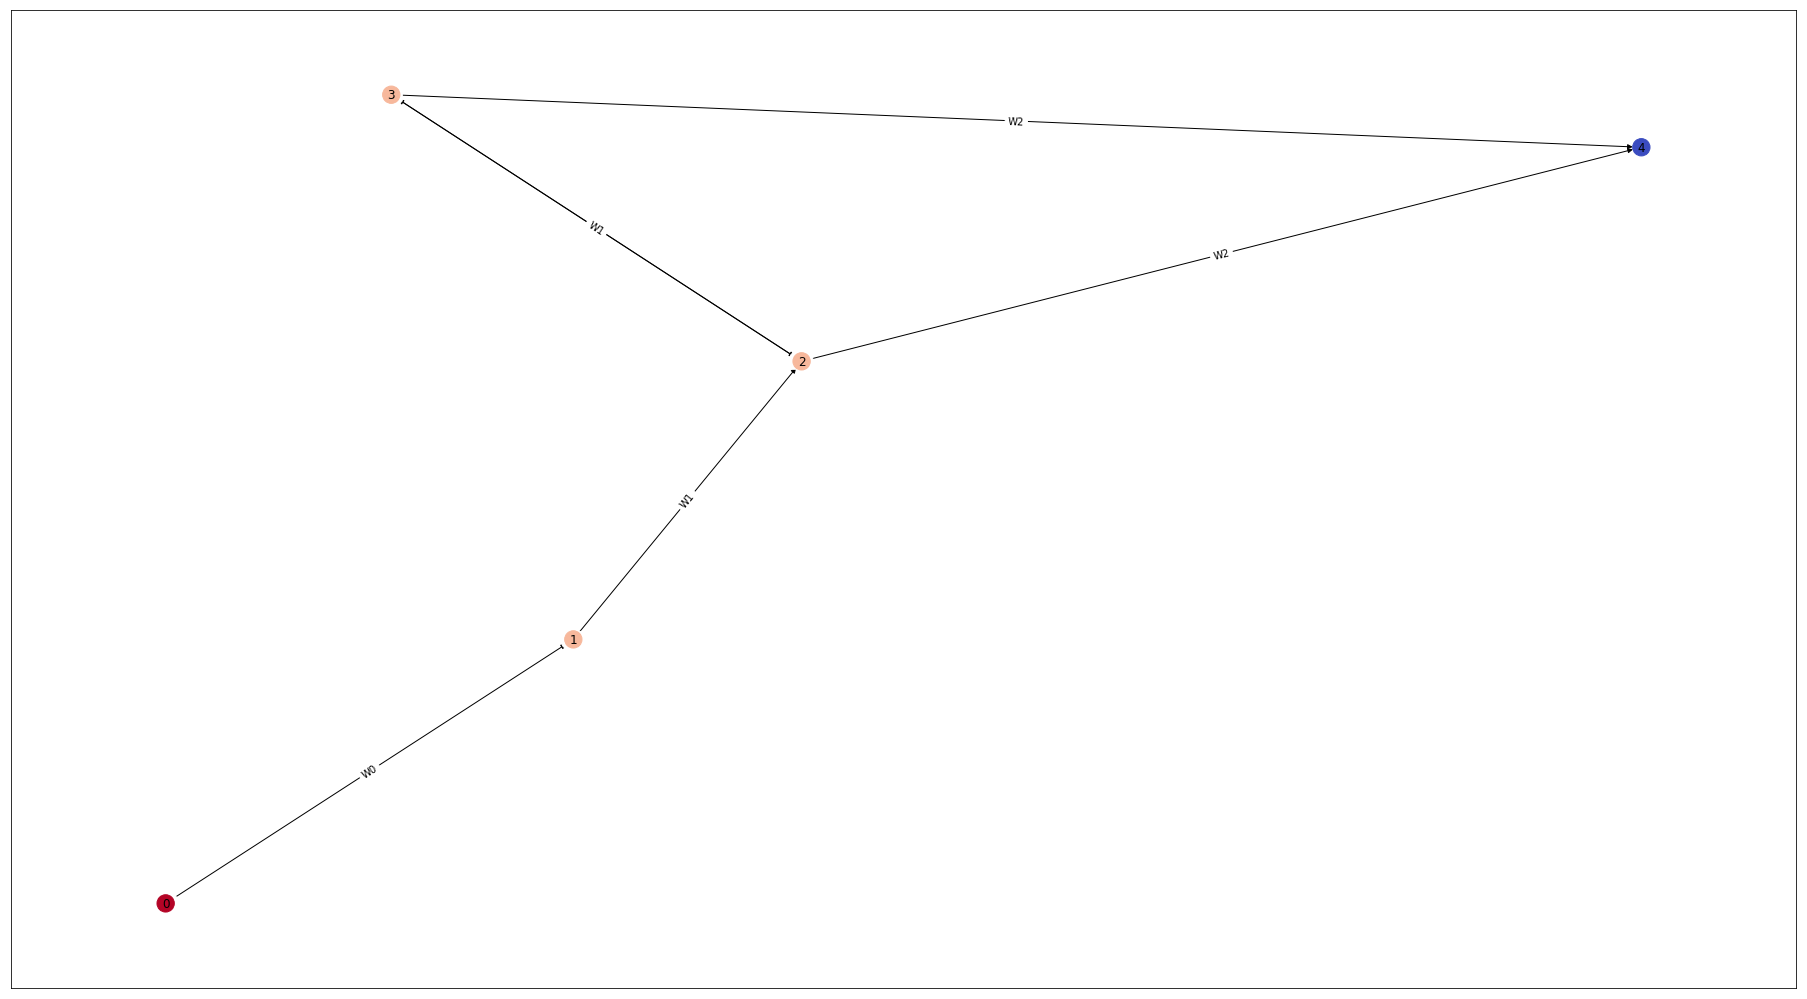

In [36]:
MDP2, fsm, cmdp = CreateSpecMDP2(reward_type='max_cover')
q_agent = QLearningAgent(MDP2)
q_agent.explore(episode_limit= 1000, verbose=True)

stoch_eval = ExplorerAgent(MDP2, input_policy = q_agent.create_learned_softmax_policy(0.02))
stoch_eval.explore(episode_limit = 1000)
_ = stoch_eval.visualize_exploration(prog='neato')

ReportEvalStates(stoch_eval)

Here every trajectory follows the most restrictive specification

Now lets conside the MAP case

Training episode 223         

Training episode 821         

Training episode 999         The average terminal reward was:  1.0
Std dev:  0.0
The average episode length was:  1.738


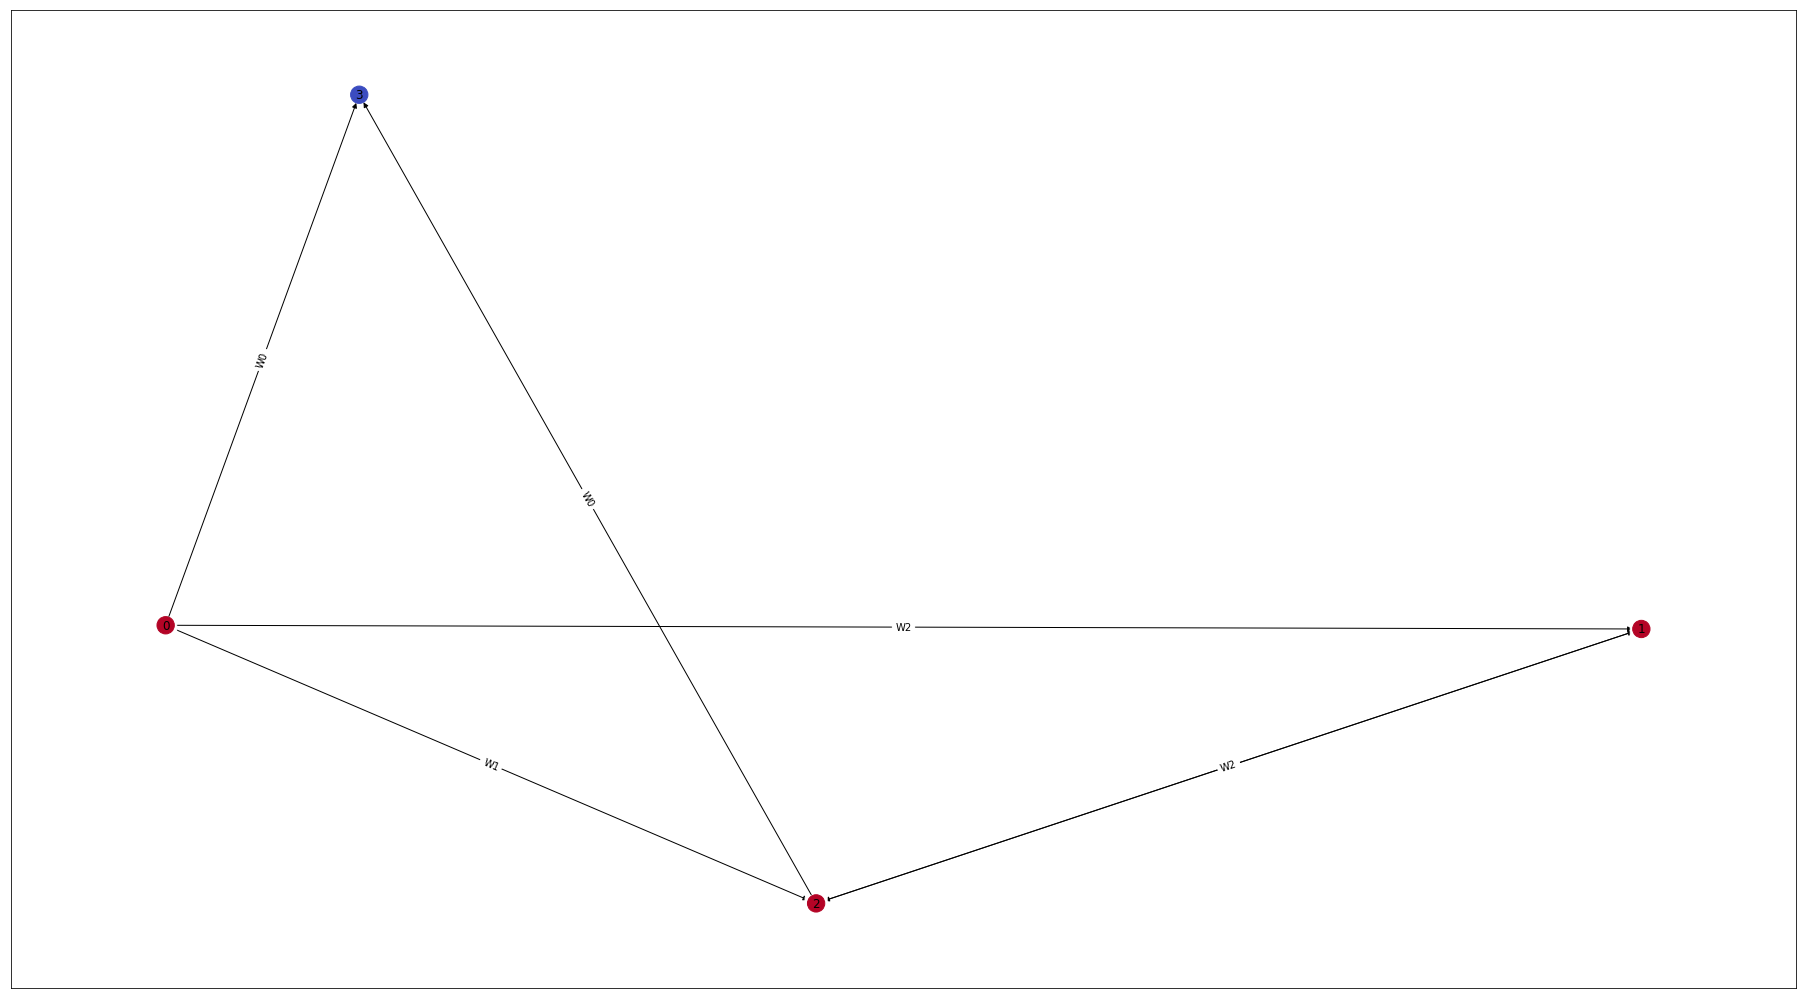

In [39]:
MDP2,fsm,cmdp = CreateSpecMDP2(reward_type='map')
q_agent = QLearningAgent(MDP2)
q_agent.explore(episode_limit= 1000, verbose=True)

stoch_eval = ExplorerAgent(MDP2, input_policy = q_agent.create_learned_softmax_policy(0.02))
stoch_eval.explore(episode_limit = 1000)
_ = stoch_eval.visualize_exploration(prog='neato')

ReportEvalStates(stoch_eval)

This is a very simple automaton and the agent always finished the task but it took many possible routes to completing the map specification (that was to visit W0)

Lets look at the chance constrained case with 15% risk

Training episode 999         The average terminal reward was:  1.0
Std dev:  0.0
The average episode length was:  4.198


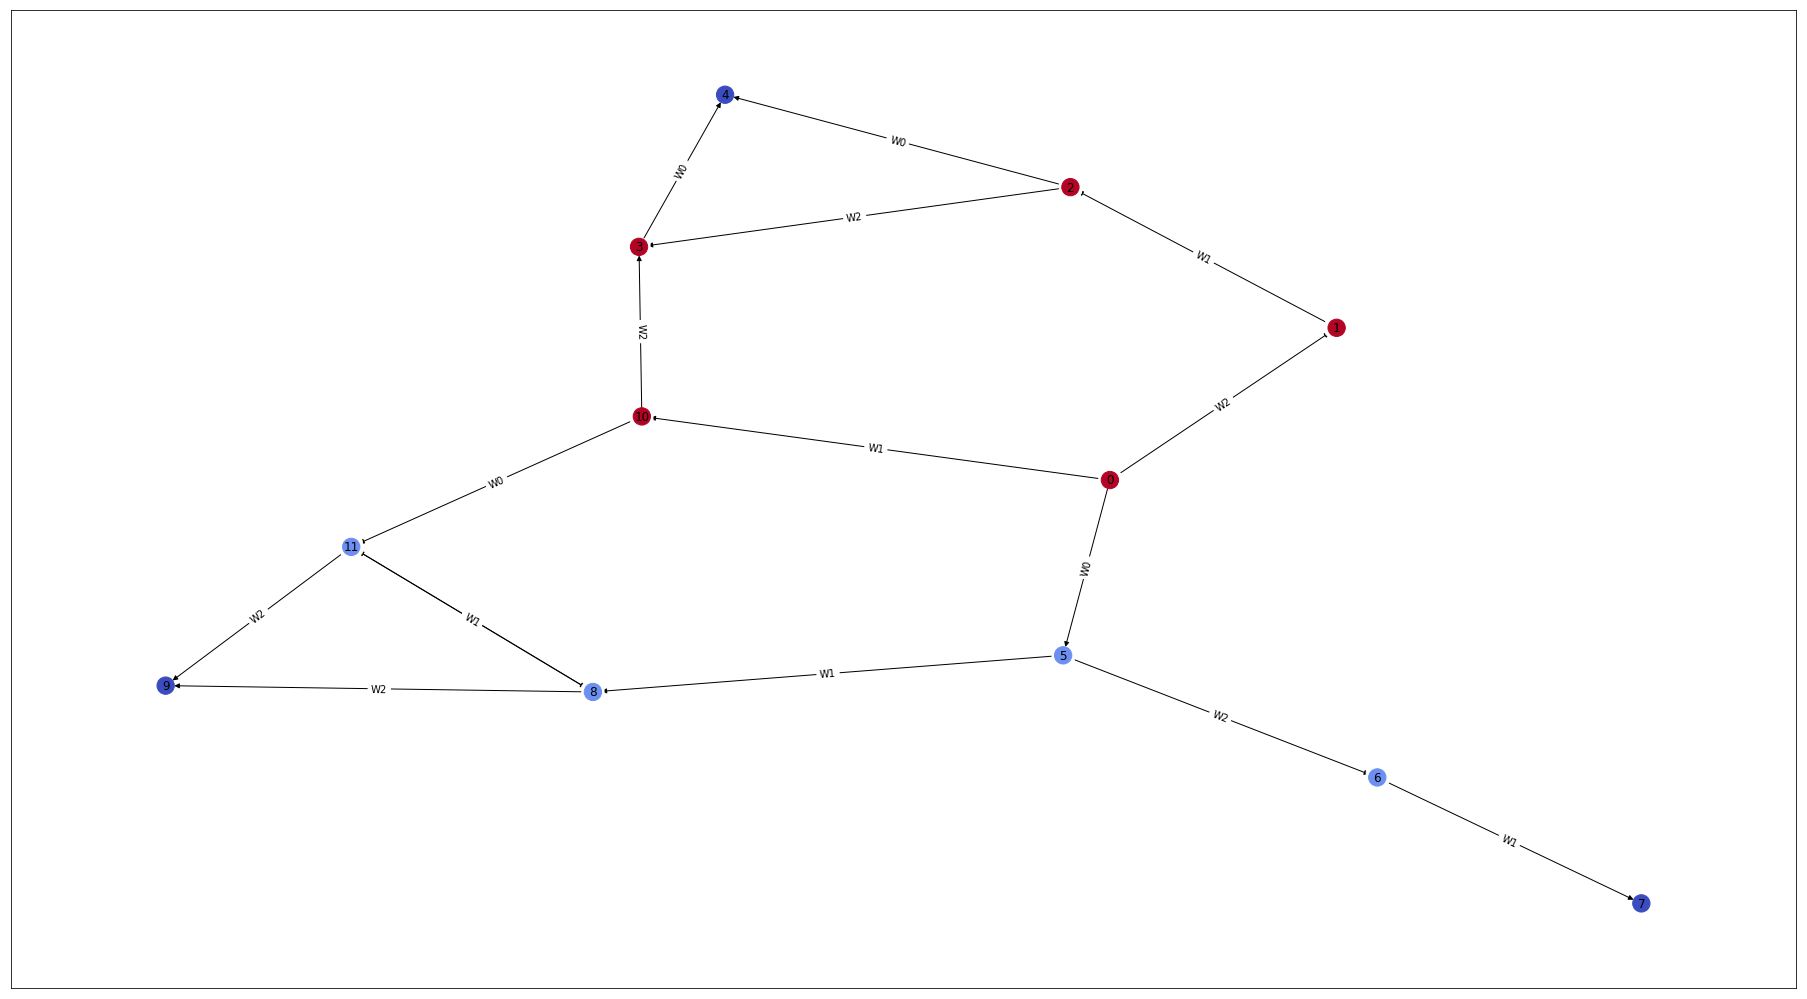

In [44]:
MDP2, fsm, cmdp = CreateSpecMDP2(reward_type = 'chance_constrained', risk_level = 0.15)
q_agent = QLearningAgent(MDP2)
q_agent.explore(episode_limit= 1000, verbose=True)

stoch_eval = ExplorerAgent(MDP2, input_policy = q_agent.create_learned_softmax_policy(0.02))
stoch_eval.explore(episode_limit = 1000)
_ = stoch_eval.visualize_exploration(prog='neato')

ReportEvalStates(stoch_eval)

This never explores only a very few paths where the ordering was maintained

## MDP3: Multiple specifications with an intersecting set ##

The specifications to plan over in this case are as follows
$$\varphi_1 = \mathbf{G} T0 ~ \wedge ~ \mathbf{F}W0$$
$$\varphi_2 = \mathbf{G} T0 ~ \wedge ~ \mathbf{F}W1$$
$$\varphi_3 = \mathbf{G} T0 ~ \wedge ~ \mathbf{F}W2$$

The probabilities are `[0.4, 0.35, 0.25]`

Lets start with the MAP case

Training episode 210         

Training episode 588         

Training episode 999         The average terminal reward was:  1.0
Std dev:  0.0
The average episode length was:  2.036


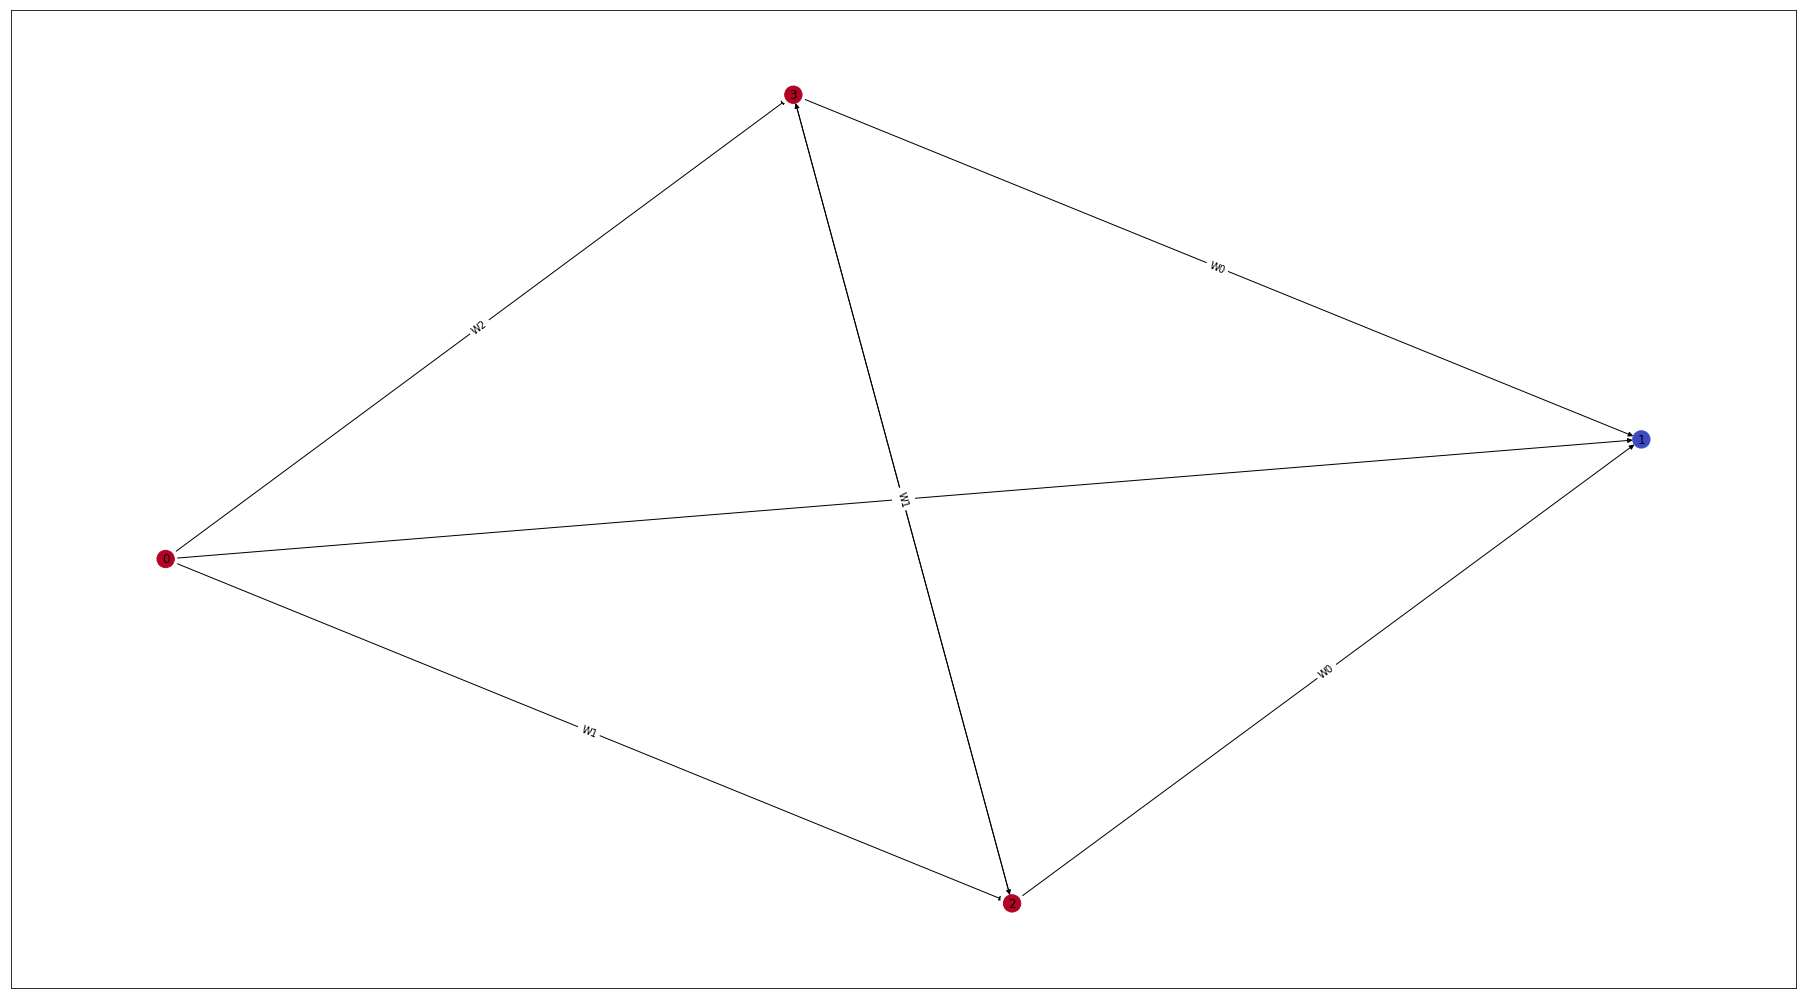

In [4]:
MDP3, fsm, cmdp = CreateSpecMDP3(reward_type='map')
q_agent = QLearningAgent(MDP3)
q_agent.explore(episode_limit= 1000, verbose=True)

stoch_eval = ExplorerAgent(MDP3, input_policy = q_agent.create_learned_softmax_policy(0.02))
stoch_eval.explore(episode_limit = 1000)
_ = stoch_eval.visualize_exploration(prog='neato')

ReportEvalStates(stoch_eval)

Now the minimum regret case

Training episode 999         The average terminal reward was:  1.0
Std dev:  0.0
The average episode length was:  4.48


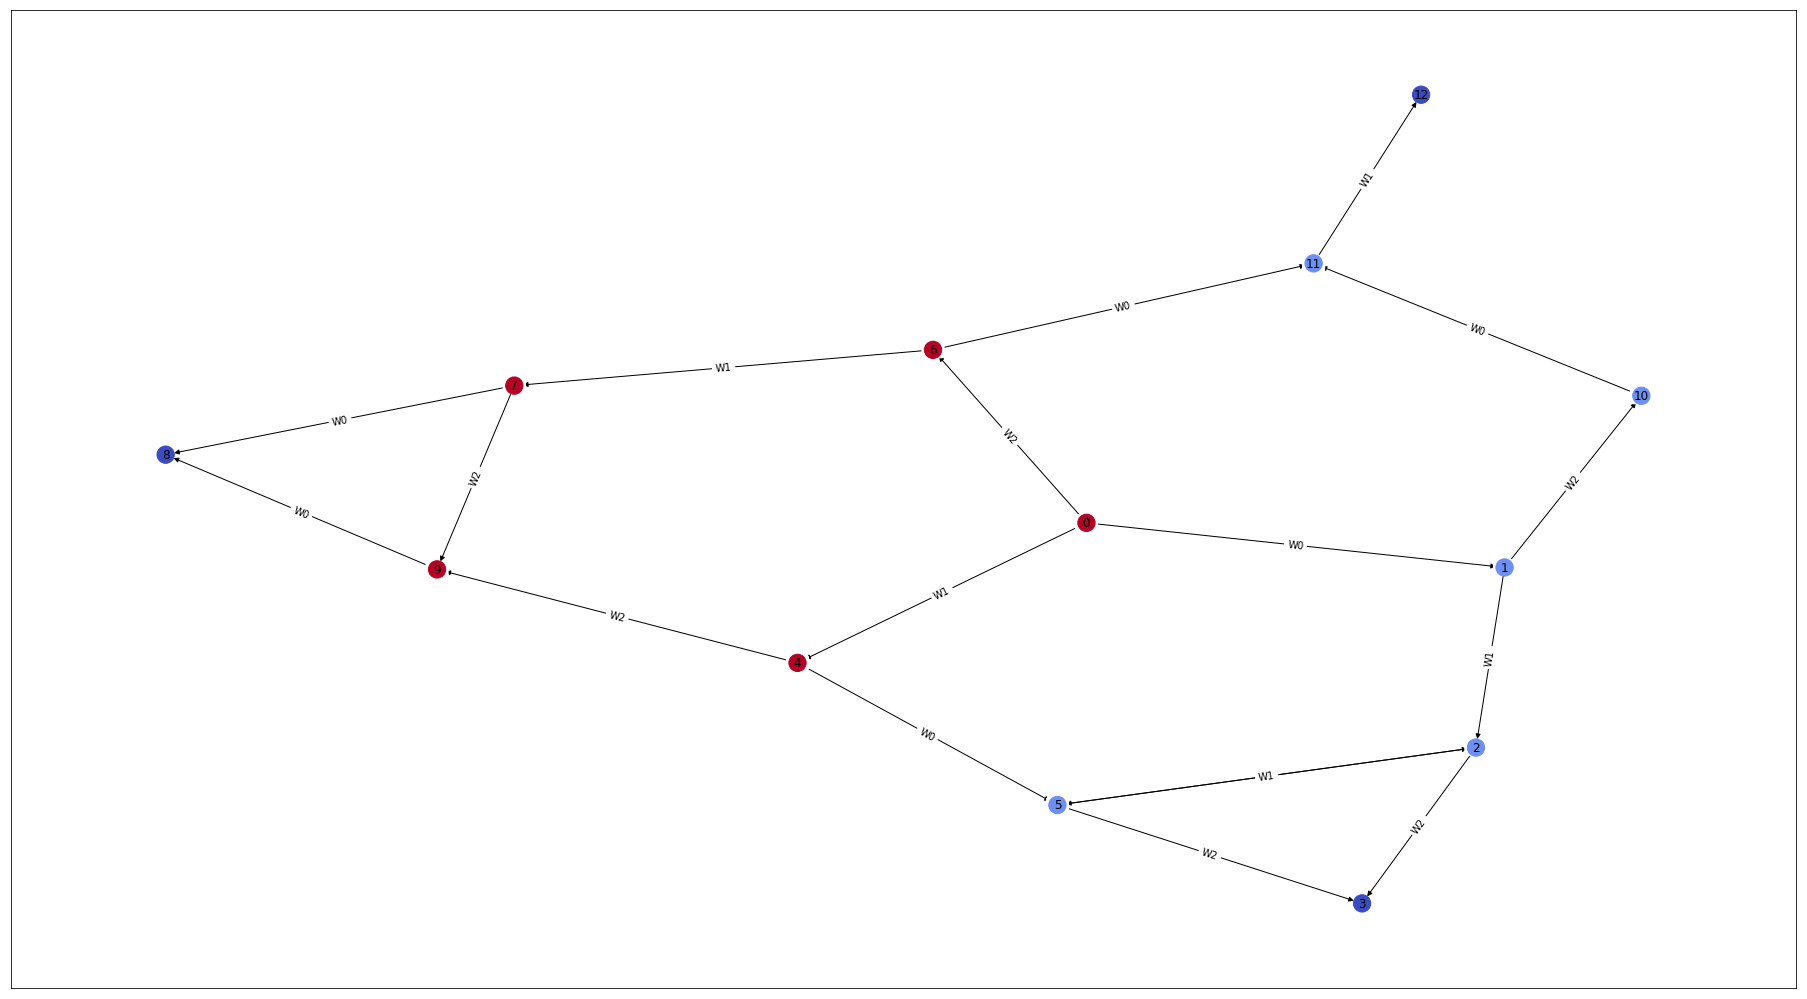

In [50]:
MDP3 = CreateSpecMDP3(reward_type='min_regret')
q_agent = QLearningAgent(MDP2)
q_agent.explore(episode_limit= 1000, verbose=True)

stoch_eval = ExplorerAgent(MDP2, input_policy = q_agent.create_learned_softmax_policy(0.02))
stoch_eval.explore(episode_limit = 1000)
_ = stoch_eval.visualize_exploration(prog='neato')

ReportEvalStates(stoch_eval)

Now for the max cover case

Training episode 999         The average terminal reward was:  1.0
Std dev:  0.0
The average episode length was:  4.886


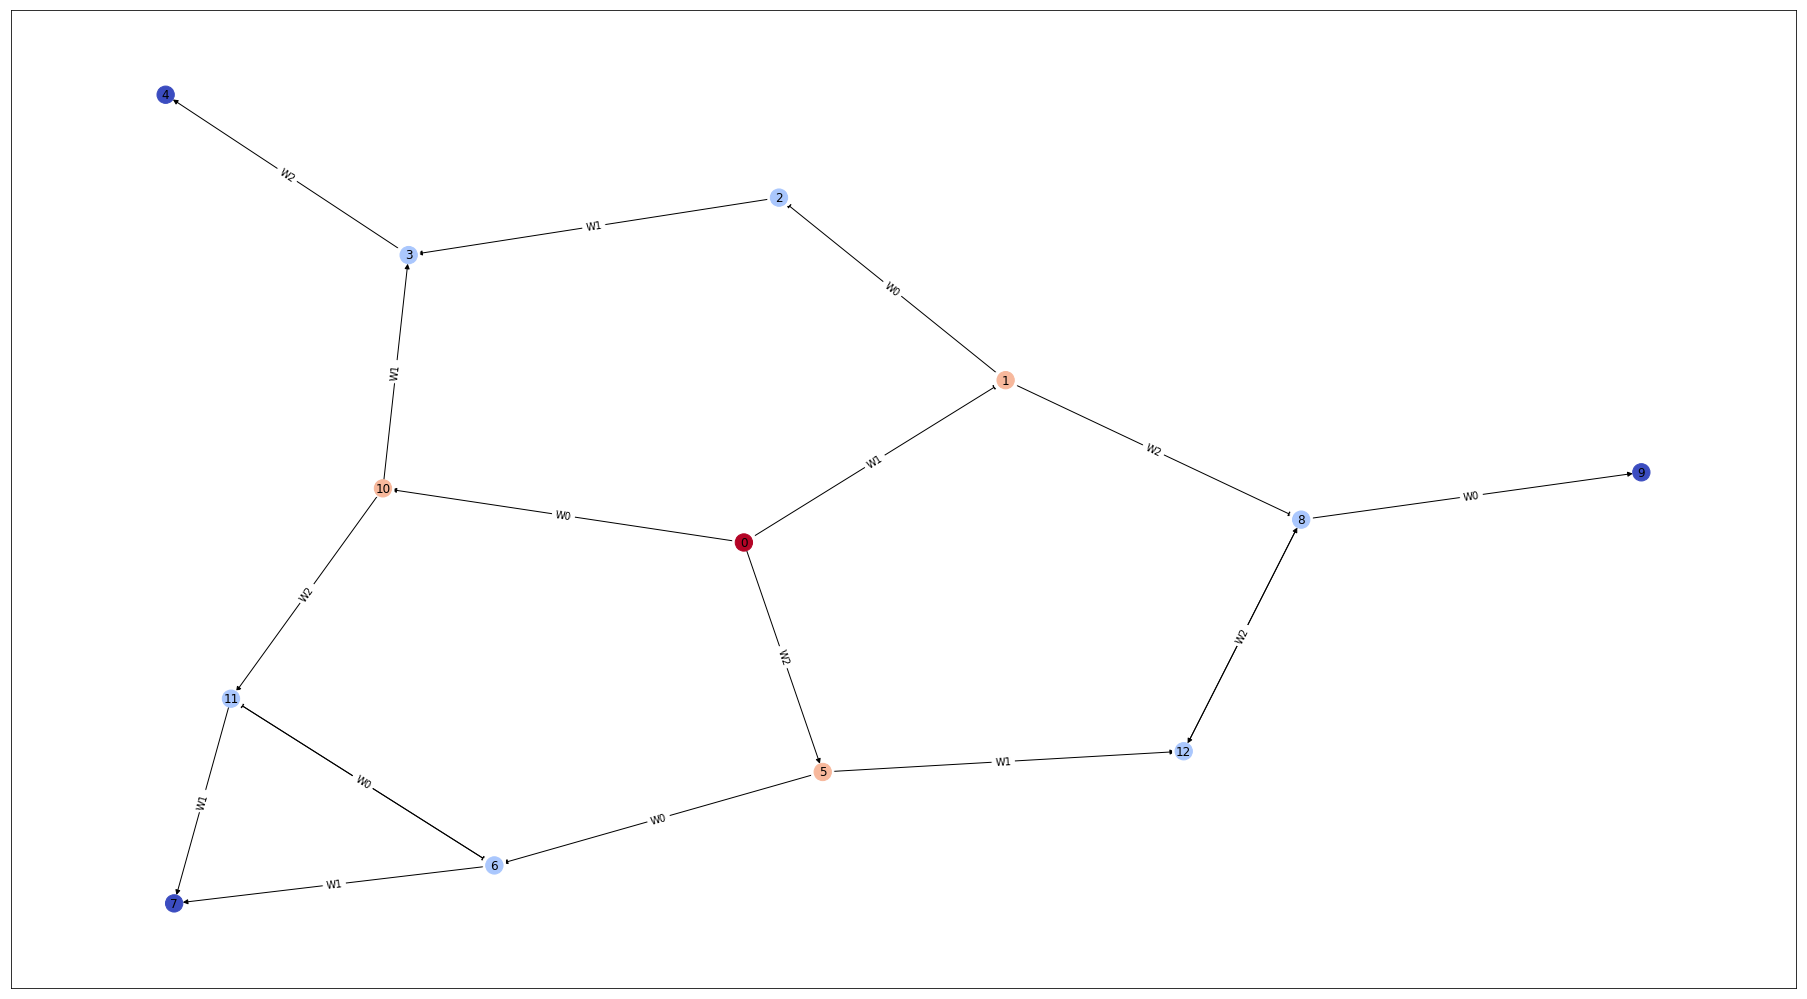

In [53]:
MDP3,fsm,cmdp = CreateSpecMDP3(reward_type='max_cover')
q_agent = QLearningAgent(MDP3)
q_agent.explore(episode_limit= 1000, verbose=True)

stoch_eval = ExplorerAgent(MDP3, input_policy = q_agent.create_learned_softmax_policy(0.02))
stoch_eval.explore(episode_limit = 1000)
_ = stoch_eval.visualize_exploration(prog='neato')

ReportEvalStates(stoch_eval)

And for the chance constrained case with risk 26%

Training episode 999         The average terminal reward was:  1.0
Std dev:  0.0
The average episode length was:  3.202


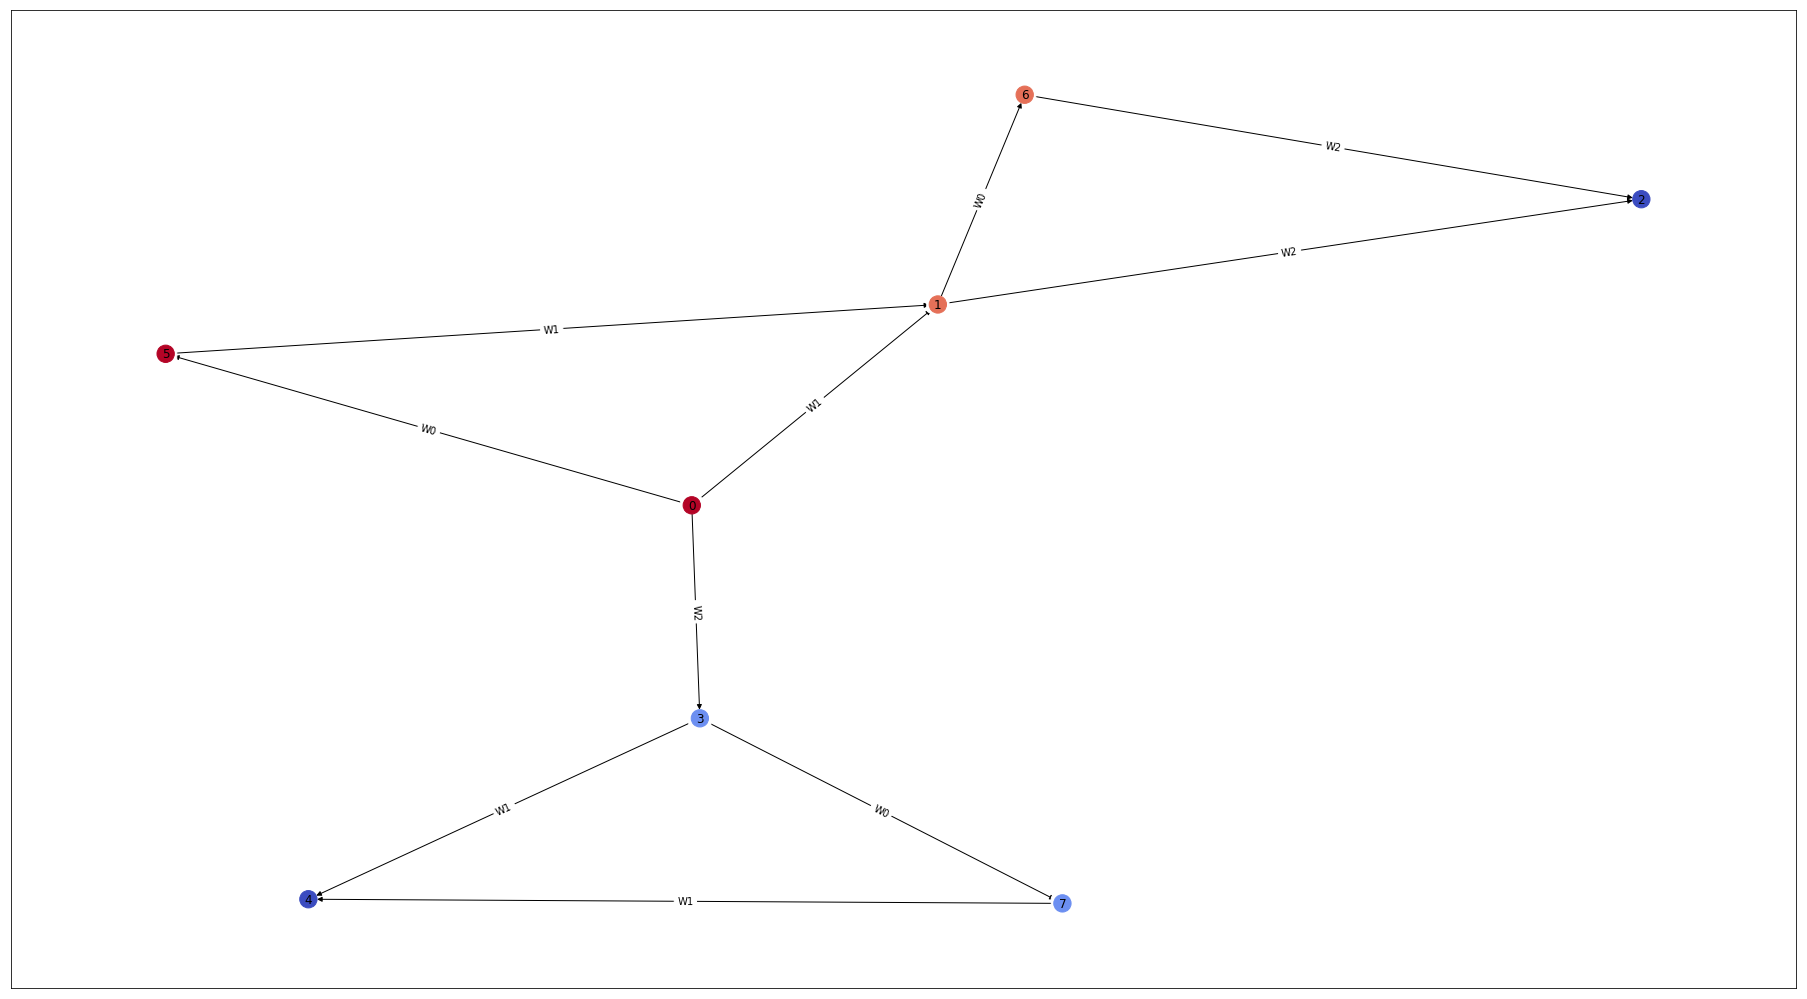

In [63]:
MDP3, fsm, cmdp = CreateSpecMDP3(reward_type='chance_constrained', risk_level=0.10)
q_agent = QLearningAgent(MDP3)
q_agent.explore(episode_limit= 1000, verbose=True)

stoch_eval = ExplorerAgent(MDP3, input_policy = q_agent.create_learned_softmax_policy(0.02))
stoch_eval.explore(episode_limit = 1000)
_ = stoch_eval.visualize_exploration(prog='neato')

ReportEvalStates(stoch_eval)

## Non overlapping specifications ##

(<networkx.classes.digraph.DiGraph at 0x7f0144f82fd0>,
 [-1.0,
  -1.0,
  0.59999999999999998,
  -0.59999999999999998,
  -0.90000000000000002,
  -0.70000000000000007])

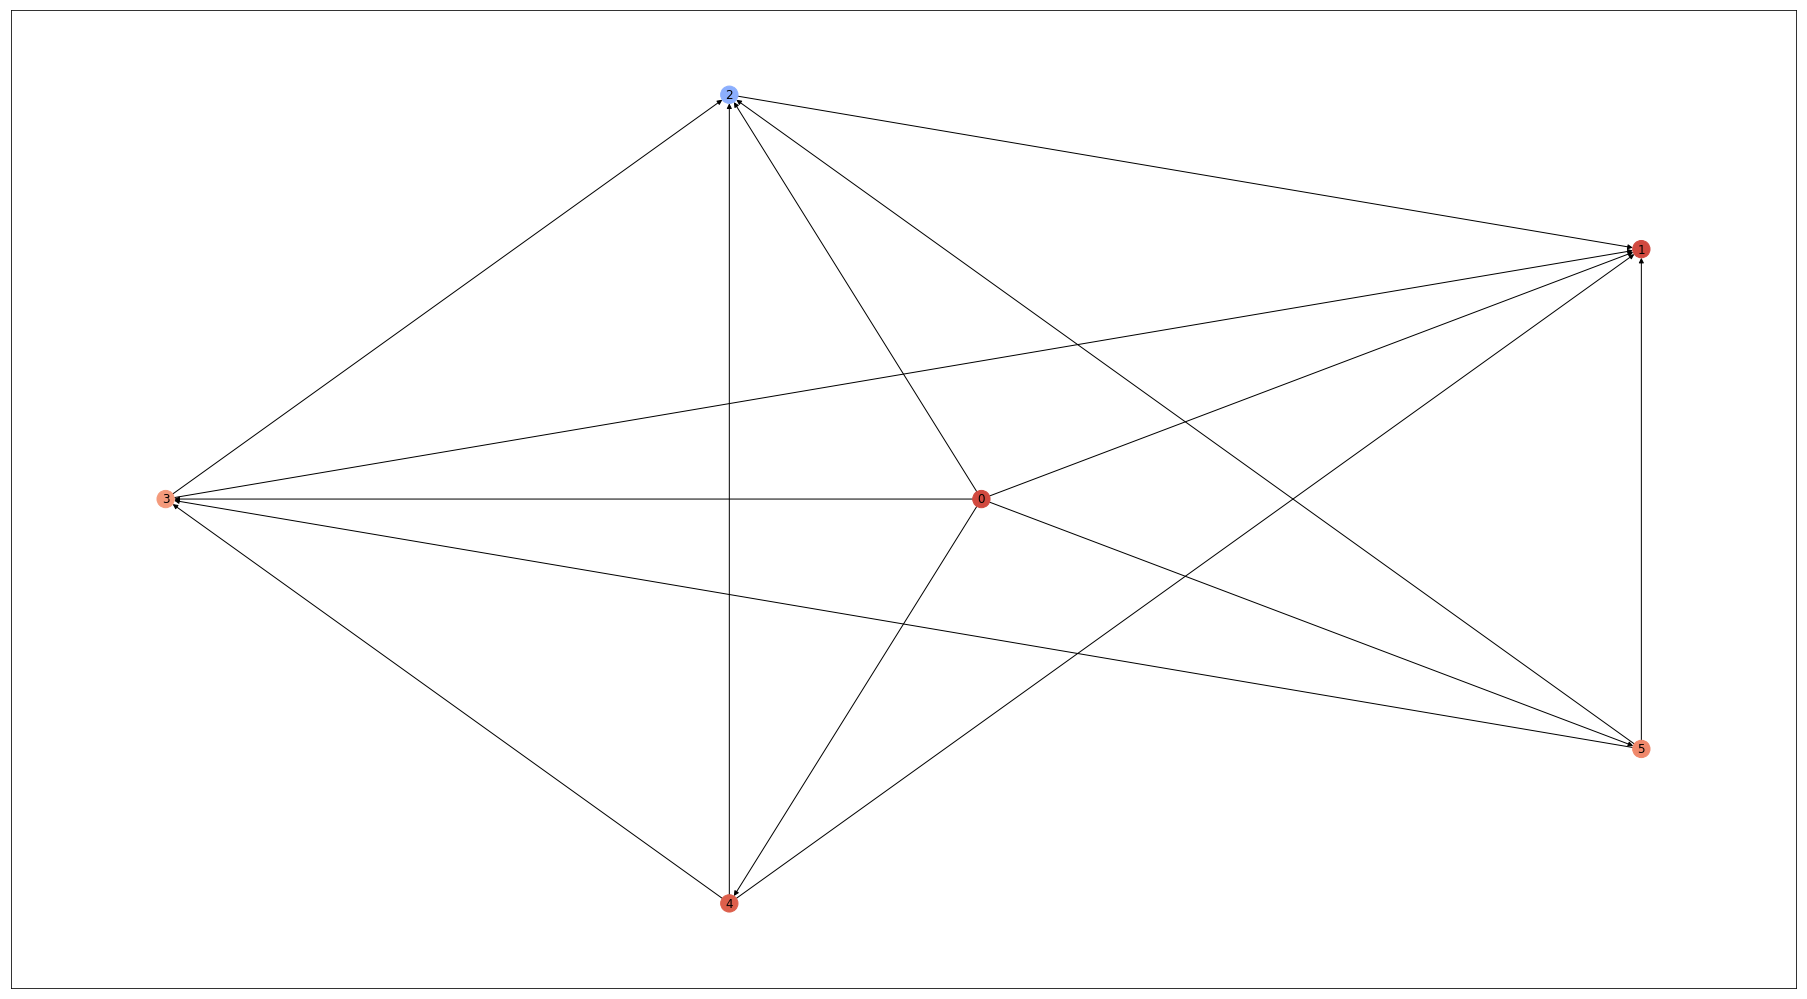

In [68]:
MDP4, fsm, cmdp = CreateSpecMDP4('min_regret')
fsm.visualize()

The average terminal reward was:  0.6
Std dev:  2.22044604925e-16
The average episode length was:  1.939


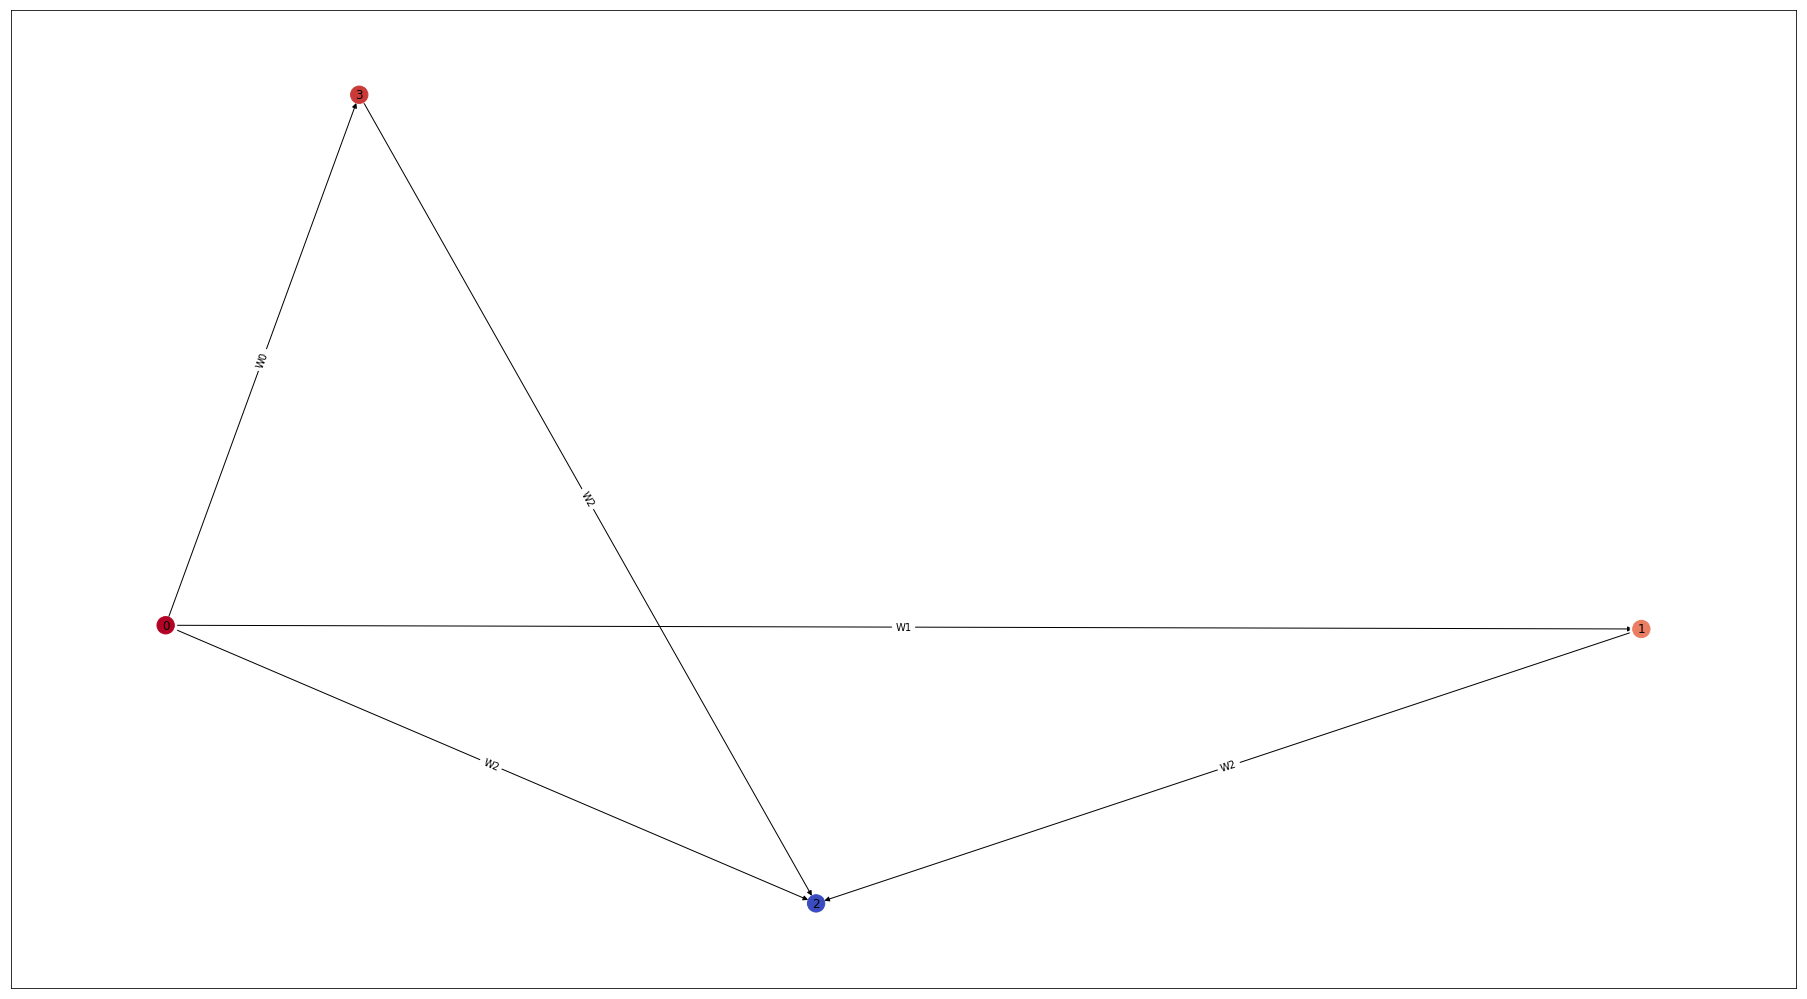

In [69]:
q_agent = QLearningAgent(MDP4)
q_agent.explore(episode_limit = 1000)

stoch_eval = ExplorerAgent(MDP4, input_policy = q_agent.create_learned_softmax_policy(0.02))
stoch_eval.explore(episode_limit = 1000)
_ = stoch_eval.visualize_exploration(prog='neato')

ReportEvalStates(stoch_eval)


The average terminal reward was:  0.333333333333
Std dev:  5.55111512313e-17
The average episode length was:  20.0


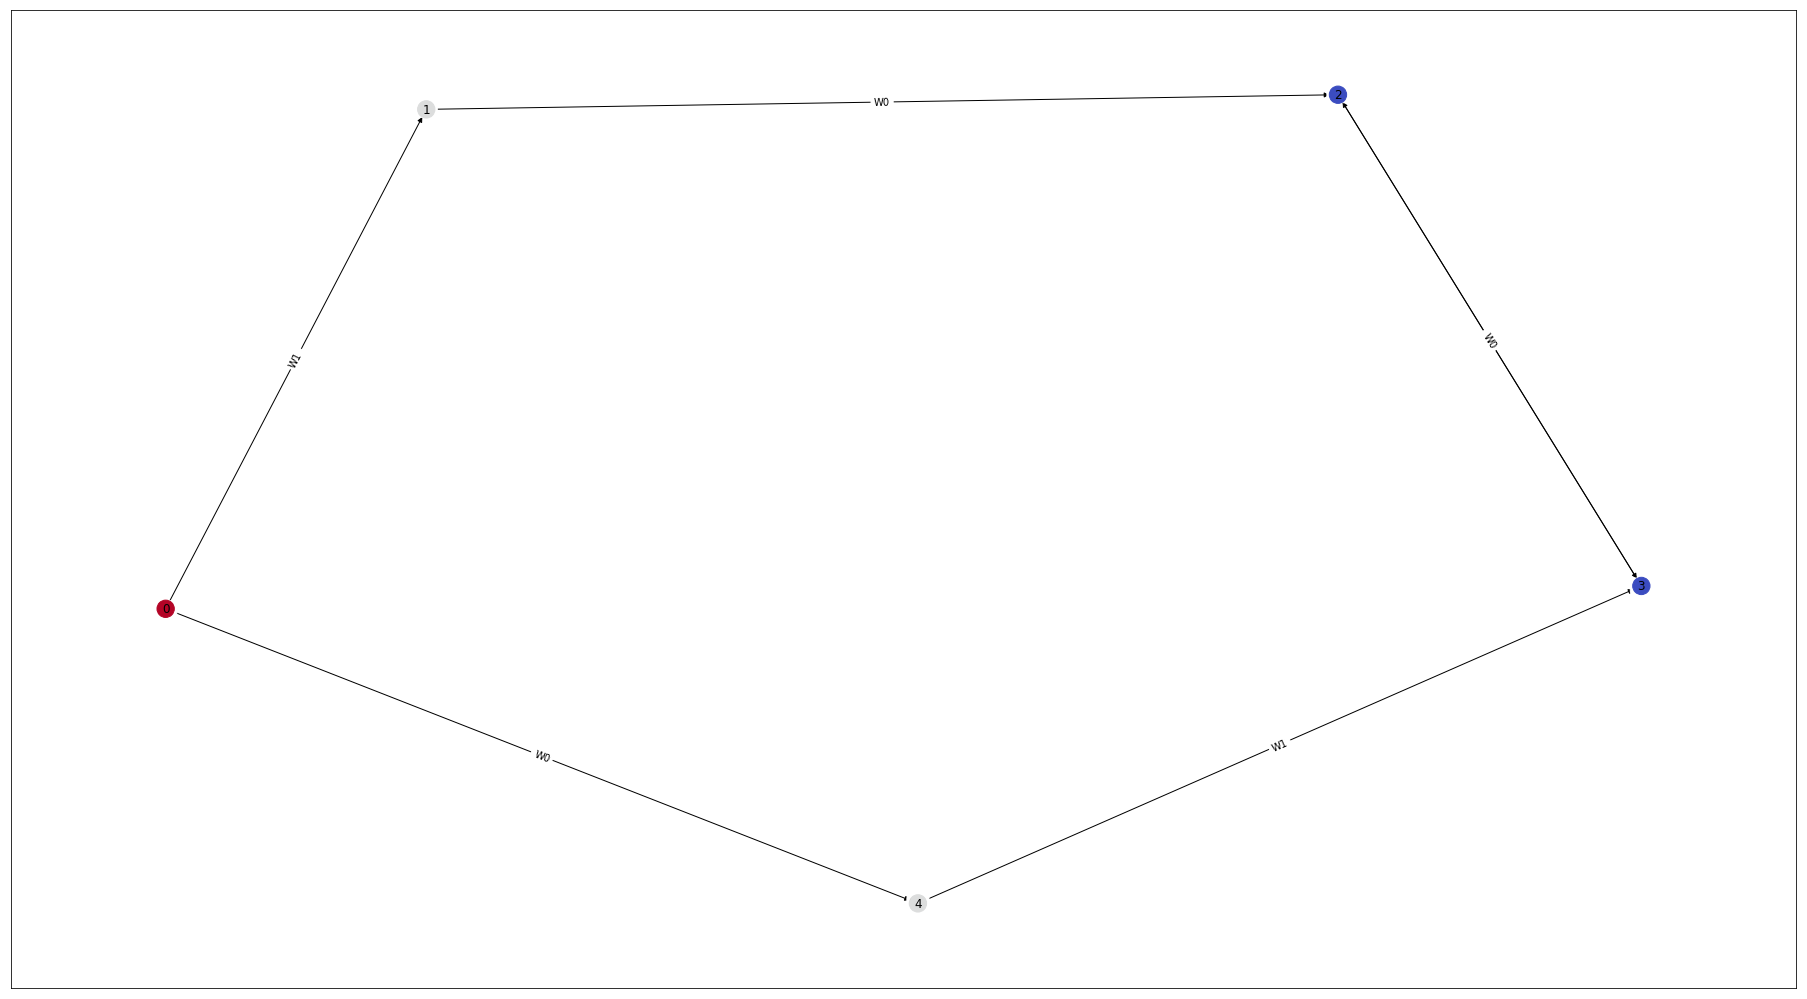

In [71]:
MDP4, fsm, cmdp = CreateSpecMDP4('max_cover')
q_agent = QLearningAgent(MDP4)
q_agent.explore(episode_limit = 1000)

stoch_eval = ExplorerAgent(MDP4, input_policy = q_agent.create_learned_softmax_policy(0.02))
stoch_eval.explore(episode_limit = 1000)
_ = stoch_eval.visualize_exploration(prog='neato')

ReportEvalStates(stoch_eval)